# BTC-USD @24h

In [26]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}
# OUT_FILENAME = './results/'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [11]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> BTC-USD: 1324 data points
  from 2015-02-28 00:00:00 to 2018-10-13 00:00:00


close   open   high    low  volume  missing
datetime                                               
2015-02-28  253.0  253.1  254.3  245.2    3.61        0

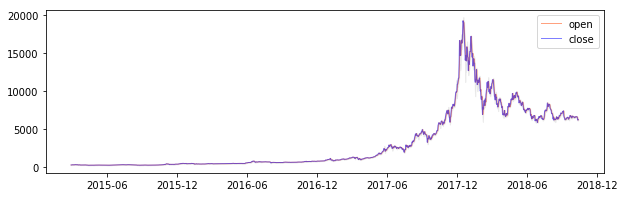

In [5]:
data_btc = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
data_btc = data_btc[data_btc.index >= '2015-02-28']
print("> BTC-USD: %d data points" % (len(data_btc),))
print("  from %s to %s" % (data_btc.iloc[0].name, data_btc.iloc[-1].name))
simple_plot(data_btc, show_xlabels=False)
dd(data_btc.head(1))



---------
> stock OSTK: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume   open   high    low  missing  weekday  \
datetime                                                              
2018-10-11  24.86  1809443.0  25.15  25.89  24.14      0.0        3   
2018-10-12  26.40  1250256.0  25.38  26.44  24.77      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

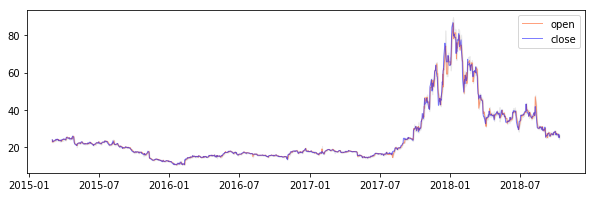



---------
> stock RIOT: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume  open    high   low  missing  weekday  close_btc  \
datetime                                                                        
2018-10-11   2.16   662046.0  2.15  2.3204  2.15      0.0        3     6161.0   
2018-10-12   2.57  4981702.0  2.22  3.1100  2.22      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

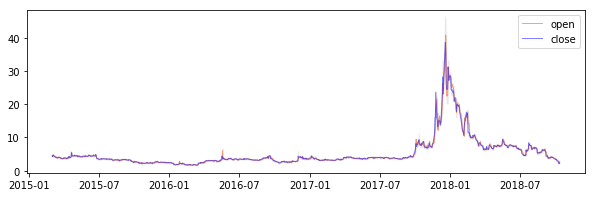



---------
> stock AMD: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close       volume   open     high    low  missing  weekday  \
datetime                                                                  
2018-10-11  25.30  146516800.0  24.74  26.2000  24.55      0.0        3   
2018-10-12  26.34  110862700.0  26.77  26.9697  25.67      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

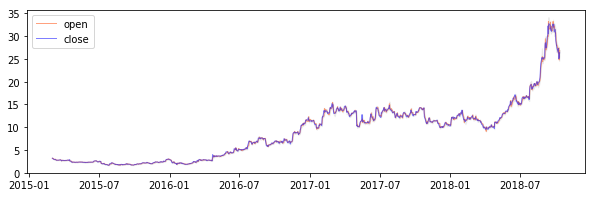



---------
> stock GBTC: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     volume   open  high   low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11   6.78  2474177.0  6.990  6.99  6.75      0.0        3     6161.0   
2018-10-12   6.85  1168809.0  6.865  6.99  6.78      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

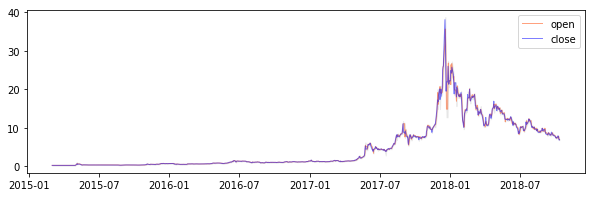



---------
> stock NVDA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close      volume      open      high      low  missing  weekday  \
datetime                                                                        
2018-10-11  235.13  18063810.0  242.1700  247.5600  234.261      0.0        3   
2018-10-12  246.54  15121060.0  245.5066  249.5412  239.650      0.0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

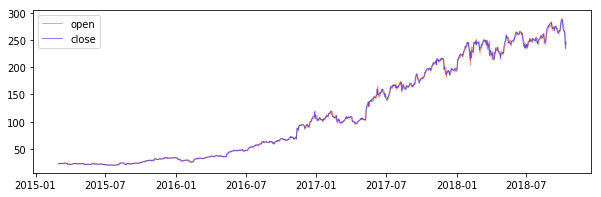



---------
> stock SIEB: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume   open   high    low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11  12.96  10389.0  13.00  13.46  12.95      0.0        3     6161.0   
2018-10-12  13.09  10455.0  13.27  13.87  13.02      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

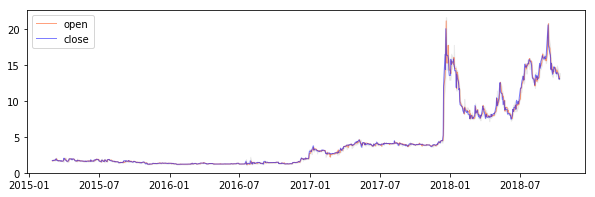



---------
> stock OTIV: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close   volume  open  high    low  missing  weekday  close_btc  \
datetime                                                                      
2018-10-11  0.9112  74004.0  0.94  0.94  0.855      0.0        3     6161.0   
2018-10-12  0.9400  64730.0  0.91  0.94  0.886      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

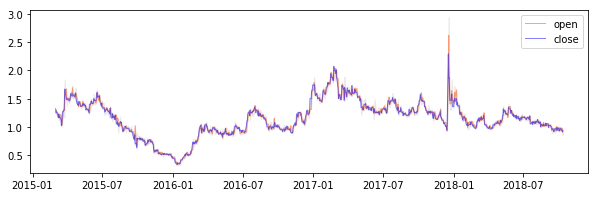



---------
> stock SP500: 914 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close     open     high      low  volume  missing  weekday  \
datetime                                                                   
2018-10-11  2728.37  2776.87  2795.14  2710.51     NaN        0        3   
2018-10-12  2767.13  2770.54  2775.77  2729.44     NaN        0        4   

            close_btc     slope_btc    r2_btc  
datetime                                       
2018-10-11     6161.0  1.055235e-13  0.274803  
2018-10-12     6184.9 -2.280879e-13  0.156982

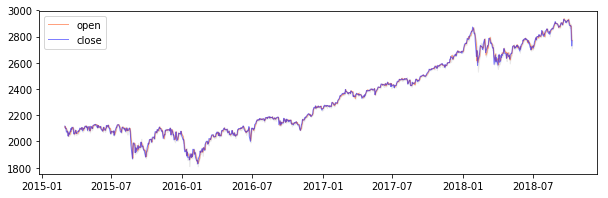



---------
> stock MARA: 945 data points
  from 2015-03-02 00:00:00 to 2018-10-12 00:00:00


close    volume  open   high   low  missing  weekday  close_btc  \
datetime                                                                       
2018-10-11  0.5850  734764.0  0.63  0.630  0.57      0.0        3     6161.0   
2018-10-12  0.6085  698911.0  0.60  0.678  0.59      0.0        4     6184.9   

               slope_btc    r2_btc  
datetime                            
2018-10-11  1.055235e-13  0.274803  
2018-10-12 -2.280879e-13  0.156982

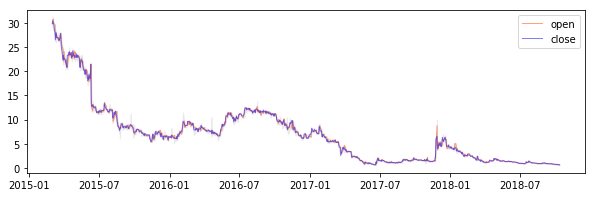

In [7]:
stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    data = etl.augment(data, data_btc, 7, '_btc')
    stocks_data[stock] = data
    print("\n\n---------")
    print("> stock %s: %d data points" % (stock.upper(), len(data)))
    print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
    dd(data.tail(2))
    simple_plot(data, show_xlabels=False)
    plt.show()

## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs .



        #################################
        # ostk
        #################################
        
data ~ (600, 8)
--- 0.020s to model compilation time


--- Created model id: 139985392045008
Tensor("lstm_181_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_181 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_181 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_182 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_182 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 4         
Total params

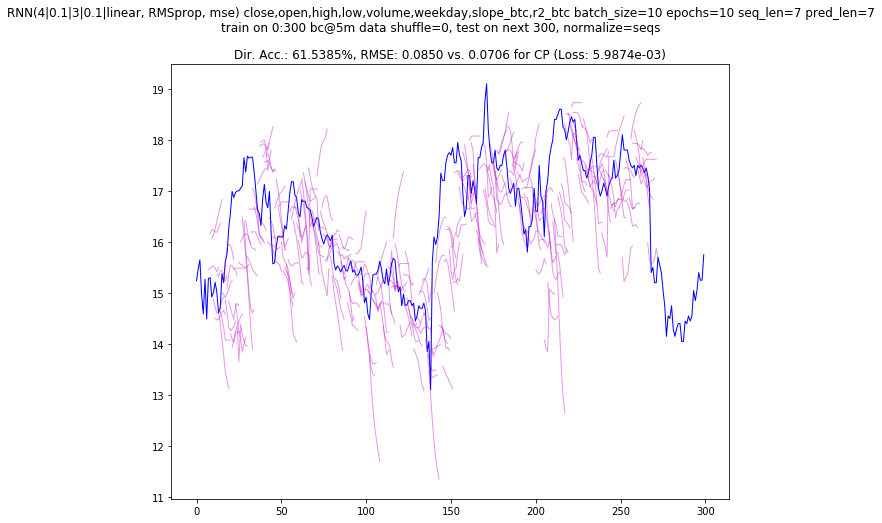

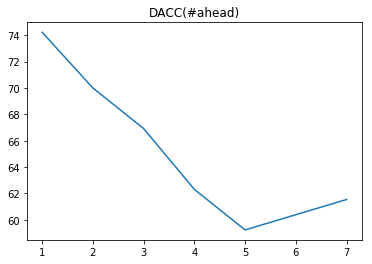

--- 30.402s to run experiment



In [21]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday', 'slope_btc', 'r2_btc'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor(
                [4, 0.1, 3, 0.1]
            ),
            # training:
            epochs=10,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (900, 8)
--- 0.014s to model compilation time


--- Created model id: 139989694823952
Tensor("lstm_25_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 4)              208       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 4)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 3)                 96        
_________________________________________________________________
dropout_26 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 4         
Total params:

> Predicting (now at 250)...
--- 1.601s to walk and predict

--- 0.245s to plot incremental predictions

--- 0.014s to model compilation time


--- Created model id: 139986540766480
Tensor("lstm_31_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 7, 4)              208       
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 4)              0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 3)                 96        
_________________________________________________________________
dropout_32 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 4         
Total params: 308
Trainable params

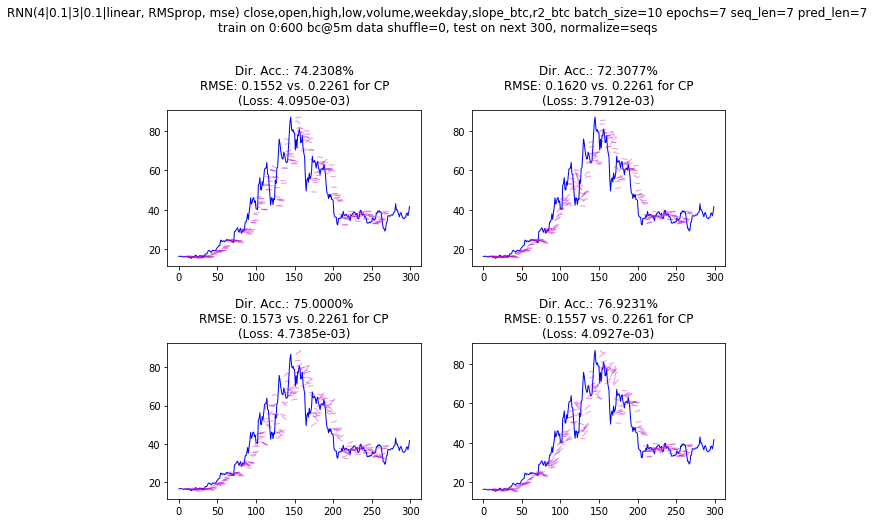

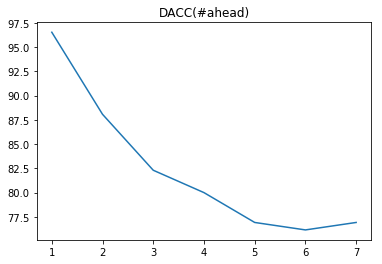

--- 35.907s to run experiment



In [12]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday', 'slope_btc', 'r2_btc'],
            from_i=0,
            train_sz=600,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor(
                [4, 0.1, 3, 0.1]
            ),
            # training:
            epochs=7,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (600, 8)
--- 0.014s to model compilation time


--- Created model id: 139986751272784
Tensor("lstm_33_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 8         
Total params:

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 4s 15ms/step - loss: 0.0131 - val_loss: 0.0064
Epoch 2/6
277/277 [==============================] - 0s 659us/step - loss: 0.0083 - val_loss: 0.0041
Epoch 3/6
277/277 [==============================] - 0s 734us/step - loss: 0.0069 - val_loss: 0.0033
Epoch 4/6
277/277 [==============================] - 0s 698us/step - loss: 0.0062 - val_loss: 0.0031
Epoch 5/6
277/277 [==============================] - 0s 713us/step - loss: 0.0060 - val_loss: 0.0032
Epoch 6/6
277/277 [==============================] - 0s 700us/step - loss: 0.0058 - val_loss: 0.0030
--- 6.676s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (n

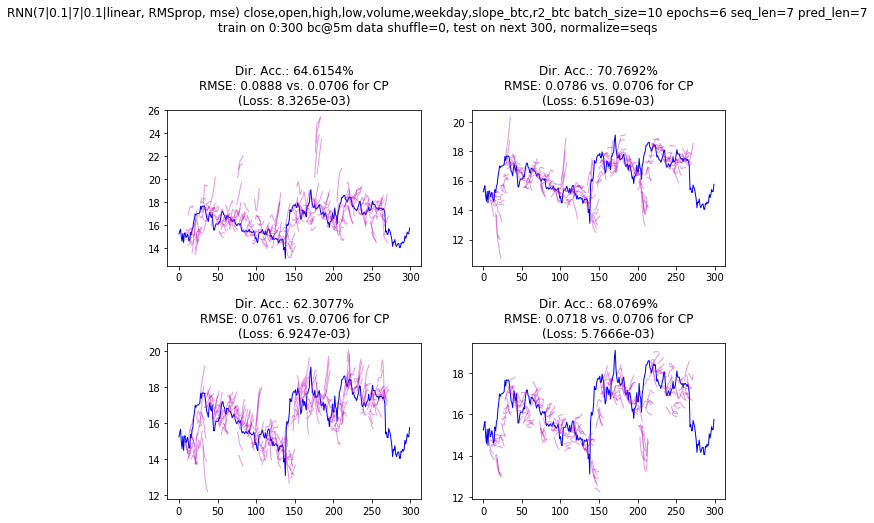

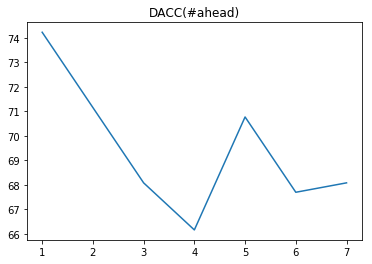

--- 34.291s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 139986396466256
Tensor("lstm_41_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_41 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_42 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)          

--- 0.016s to model compilation time


--- Created model id: 139986348594768
Tensor("lstm_47_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_47 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_48 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________
None
Tens

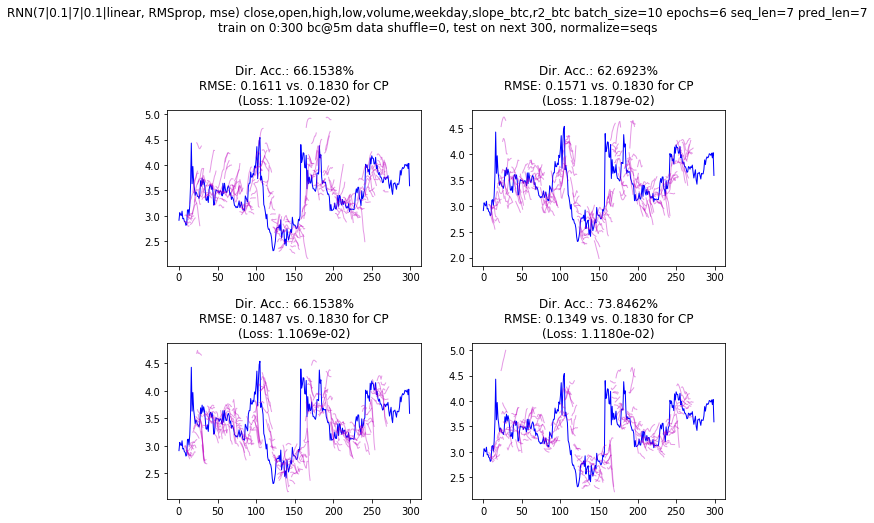

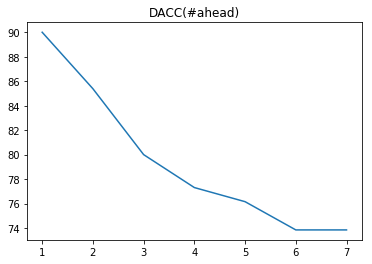

--- 36.844s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 139986323911056
Tensor("lstm_49_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_50 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)           

--- 0.015s to model compilation time


--- Created model id: 139986261968976
Tensor("lstm_55_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_56 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________
None
Tens

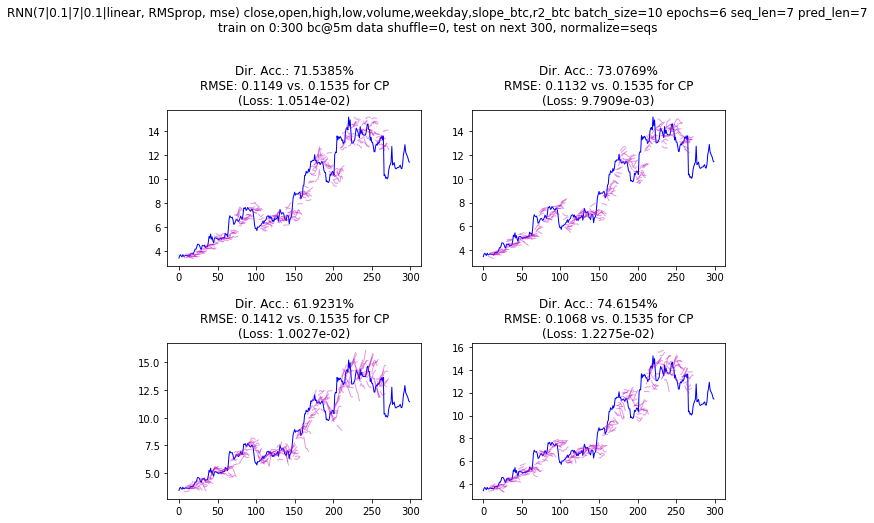

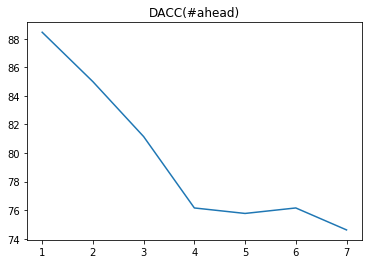

--- 40.646s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 139986252220496
Tensor("lstm_57_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)          

--- 0.014s to model compilation time


--- Created model id: 139986192124112
Tensor("lstm_63_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_63 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_64 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________
None
Tens

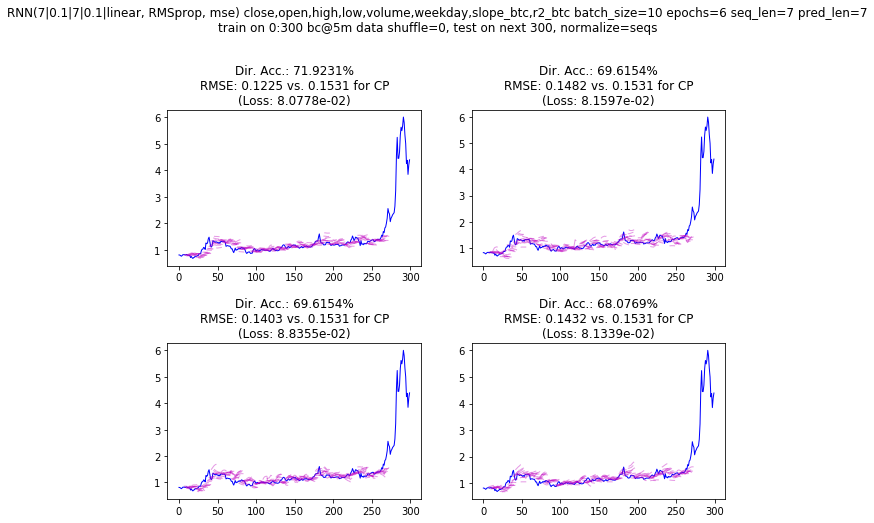

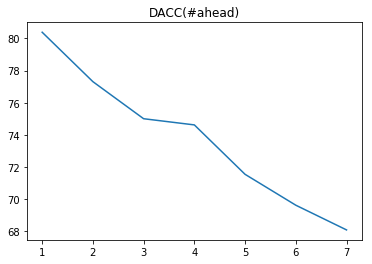

--- 43.693s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 8)
--- 0.014s to model compilation time


--- Created model id: 139986166936528
Tensor("lstm_65_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_65 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_66 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)          

--- 3.341s to walk and predict

--- 0.350s to plot incremental predictions

--- 0.022s to model compilation time


--- Created model id: 139986187694032
Tensor("lstm_71_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_71 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_72 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0

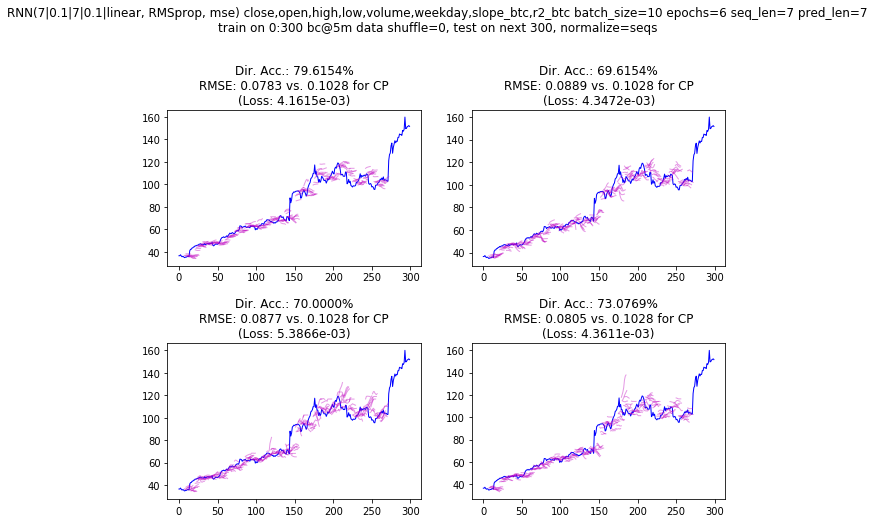

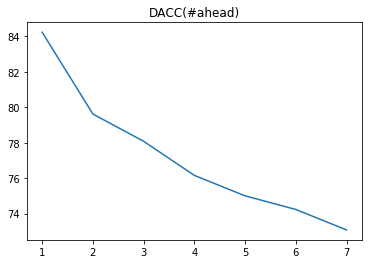

--- 51.209s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 8)
--- 0.019s to model compilation time


--- Created model id: 139986116344592
Tensor("lstm_73_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_73 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_74 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)          

--- 0.016s to model compilation time


--- Created model id: 139986059982416
Tensor("lstm_79_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_79 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_80 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________
None
Tens

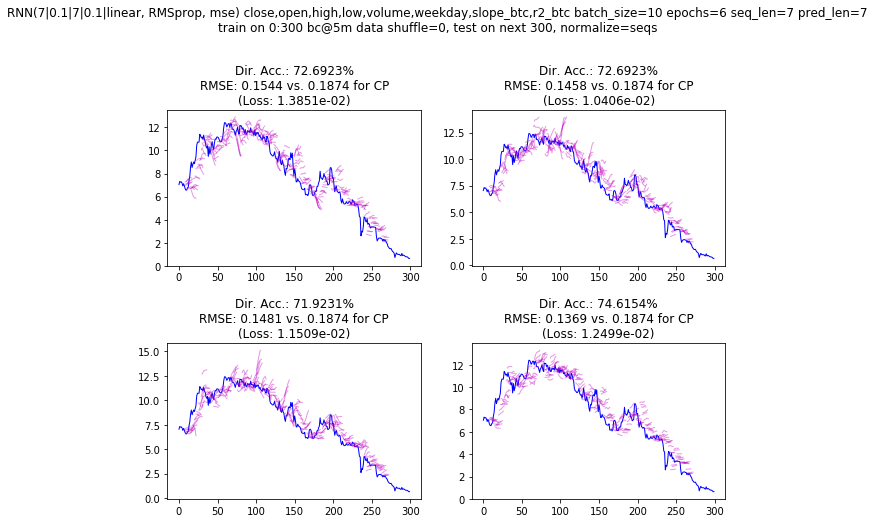

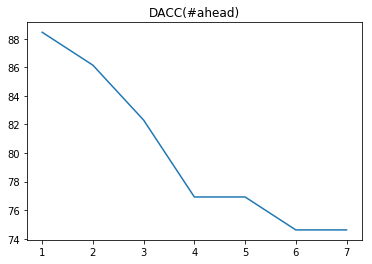

--- 54.305s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 139986032709840
Tensor("lstm_81_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_82 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)          

--- 0.015s to model compilation time


--- Created model id: 139986006434960
Tensor("lstm_87_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_87 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_88 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________
None
Tens

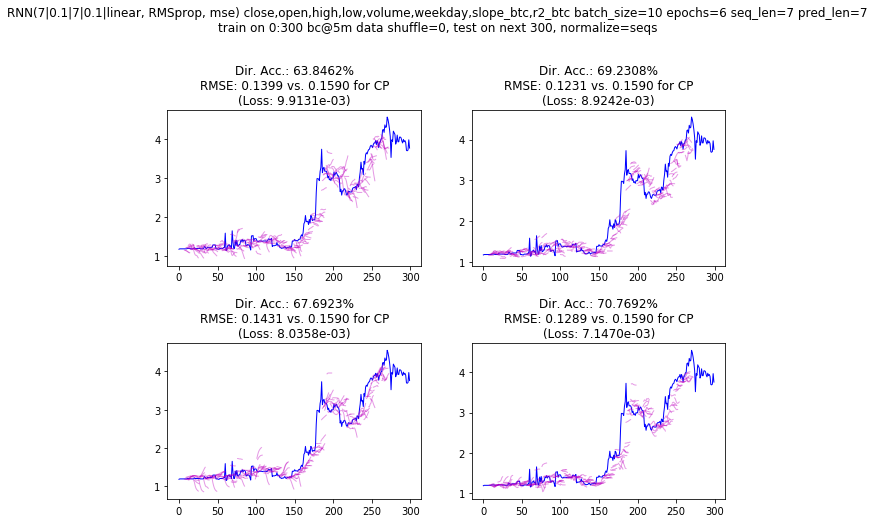

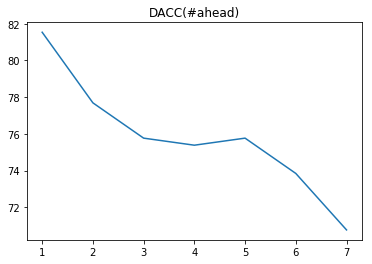

--- 56.572s to run experiment



        #################################
        # sp500
        #################################
        
data ~ (600, 8)
--- 0.014s to model compilation time


--- Created model id: 139985981476752
Tensor("lstm_89_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_89 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_90 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)         

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<Figure size 720x576 with 0 Axes>

In [13]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday', 'slope_btc', 'r2_btc'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 8)
--- 0.017s to model compilation time


--- Created model id: 139985876994576
Tensor("lstm_99_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_99 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_100 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 8         
Total params:

277/277 [==============================] - 0s 749us/step - loss: 0.0056 - val_loss: 0.0043
Epoch 8/10
277/277 [==============================] - 0s 713us/step - loss: 0.0061 - val_loss: 0.0035
Epoch 9/10
277/277 [==============================] - 0s 701us/step - loss: 0.0058 - val_loss: 0.0034
Epoch 10/10
277/277 [==============================] - 0s 706us/step - loss: 0.0054 - val_loss: 0.0037
--- 12.066s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Pre

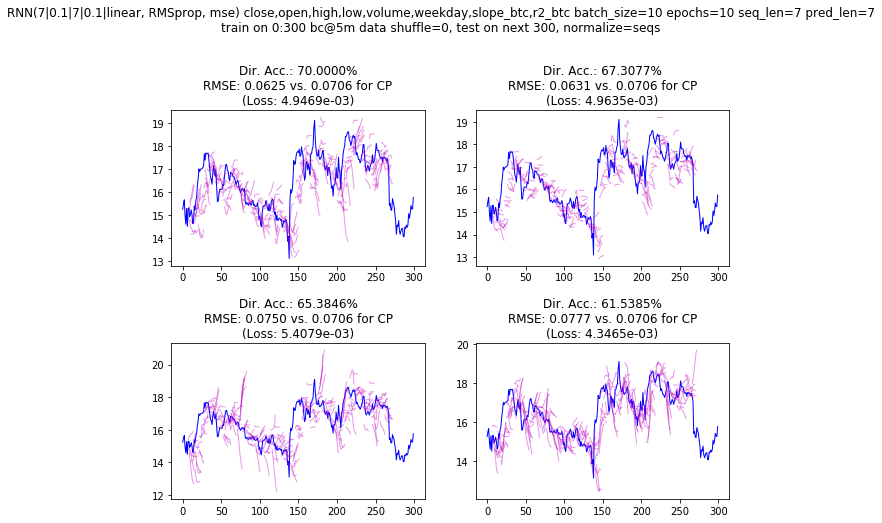

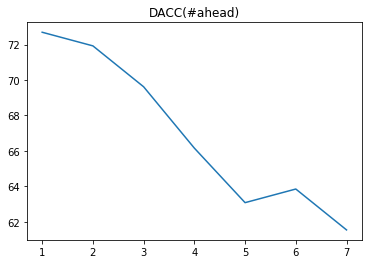

--- 68.141s to run experiment



In [15]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday', 'slope_btc', 'r2_btc'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
            # training:
            epochs=10,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.



        #################################
        # ostk
        #################################
        
data ~ (600, 8)
--- 0.017s to model compilation time


--- Created model id: 139985876595024
Tensor("lstm_107_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_107 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_107 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_108 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_108 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 4         
Total params

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 10s 35ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 2/3
277/277 [==============================] - 0s 609us/step - loss: 0.0057 - val_loss: 0.0024
Epoch 3/3
277/277 [==============================] - 0s 597us/step - loss: 0.0054 - val_loss: 0.0024
--- 11.586s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

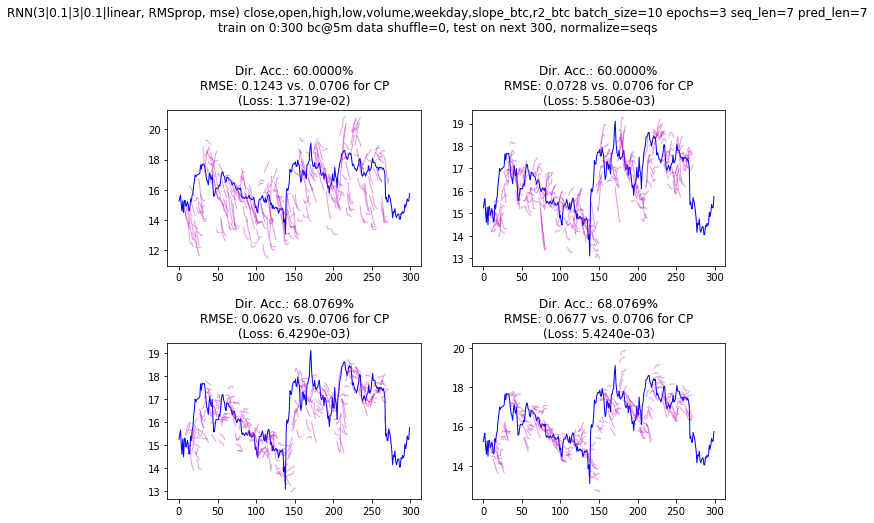

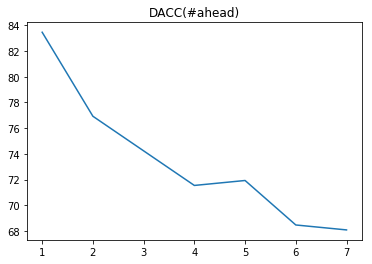

--- 65.824s to run experiment



        #################################
        # riot
        #################################
        
data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 139985731740496
Tensor("lstm_115_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_115 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_116 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_116 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)         

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 11s 38ms/step - loss: 0.0243 - val_loss: 0.0284
Epoch 2/3
277/277 [==============================] - 0s 656us/step - loss: 0.0195 - val_loss: 0.0290
Epoch 3/3
277/277 [==============================] - 0s 674us/step - loss: 0.0183 - val_loss: 0.0295
--- 14.310s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

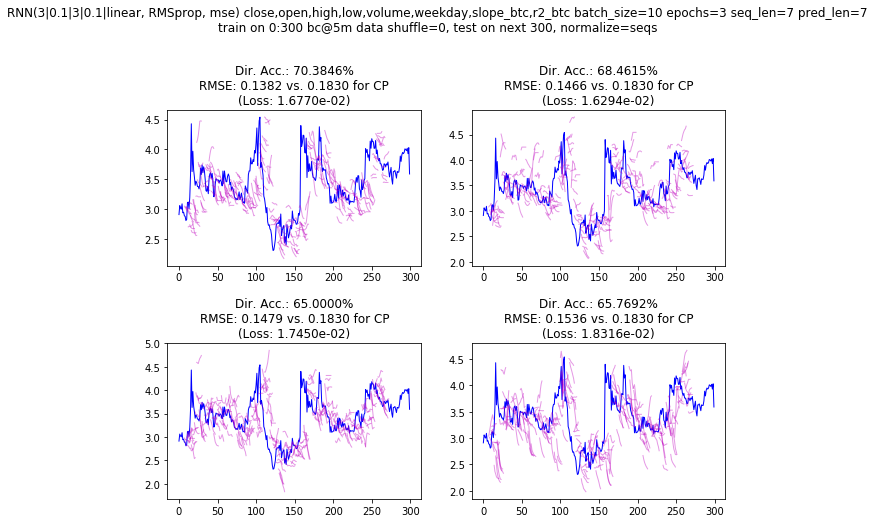

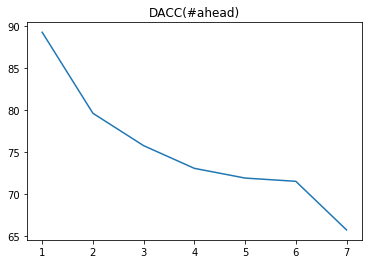

--- 71.753s to run experiment



        #################################
        # amd
        #################################
        
data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 139985846101264
Tensor("lstm_123_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_123 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_124 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_124 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)          

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 11s 40ms/step - loss: 0.0138 - val_loss: 0.0029
Epoch 2/3
277/277 [==============================] - 0s 762us/step - loss: 0.0118 - val_loss: 0.0029
Epoch 3/3
277/277 [==============================] - 0s 807us/step - loss: 0.0115 - val_loss: 0.0026
--- 13.180s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

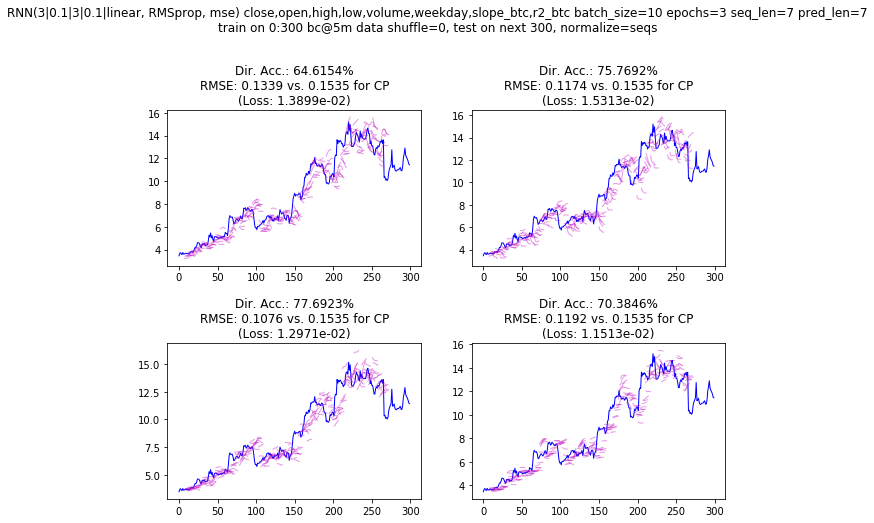

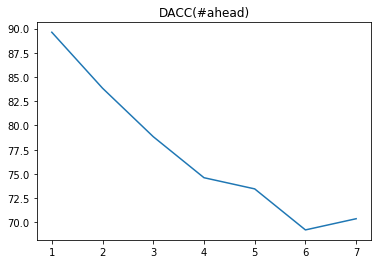

--- 74.174s to run experiment



        #################################
        # gbtc
        #################################
        
data ~ (600, 8)
--- 0.017s to model compilation time


--- Created model id: 139985590729744
Tensor("lstm_131_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_131 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_132 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)         

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 12s 42ms/step - loss: 0.0897 - val_loss: 0.0082
Epoch 2/3
277/277 [==============================] - 0s 685us/step - loss: 0.0888 - val_loss: 0.0057
Epoch 3/3
277/277 [==============================] - 0s 654us/step - loss: 0.0870 - val_loss: 0.0045
--- 13.764s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

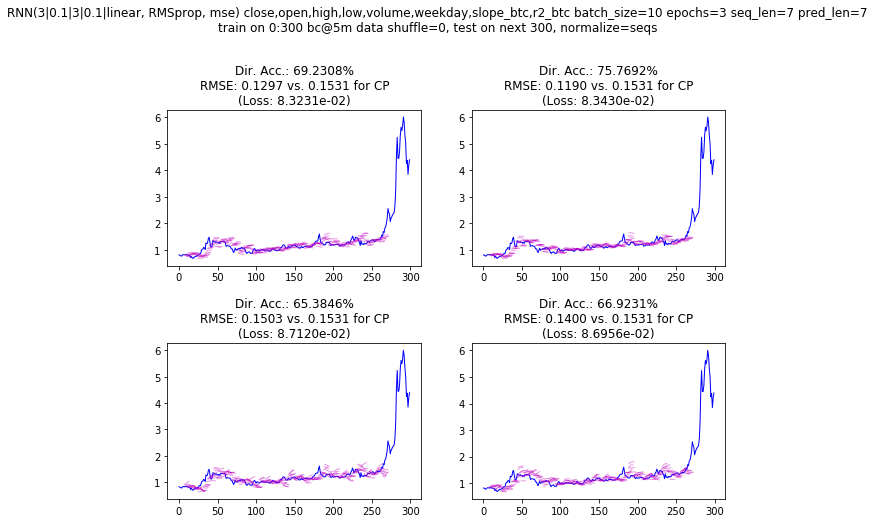

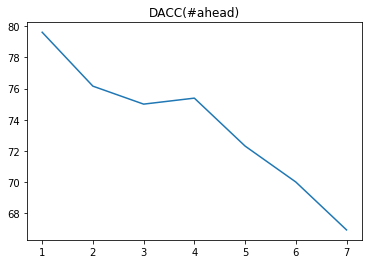

--- 77.784s to run experiment



        #################################
        # nvda
        #################################
        
data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 139985502915728
Tensor("lstm_139_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_139 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_140 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_140 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)         

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 13s 46ms/step - loss: 0.0085 - val_loss: 0.0047
Epoch 2/3
277/277 [==============================] - 0s 732us/step - loss: 0.0066 - val_loss: 0.0032
Epoch 3/3
277/277 [==============================] - 0s 770us/step - loss: 0.0055 - val_loss: 0.0025
--- 14.870s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

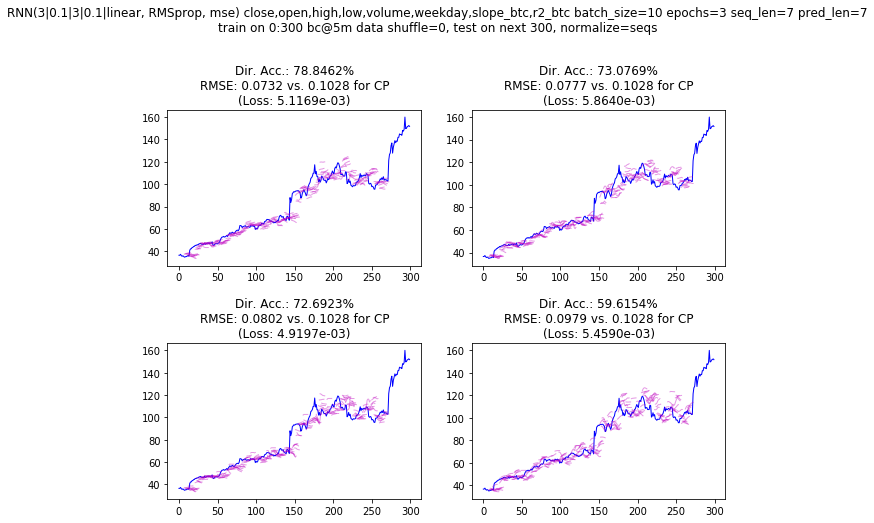

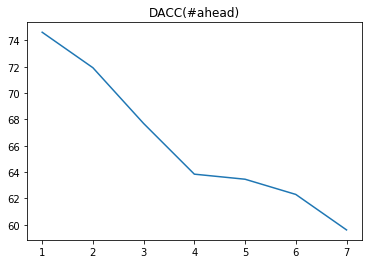

--- 82.844s to run experiment



        #################################
        # mara
        #################################
        
data ~ (600, 8)
--- 0.017s to model compilation time


--- Created model id: 139985415055632
Tensor("lstm_147_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_147 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_148 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_148 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)         

Train on 277 samples, validate on 15 samples
Epoch 1/3
277/277 [==============================] - 14s 51ms/step - loss: 0.0346 - val_loss: 0.0602
Epoch 2/3
277/277 [==============================] - 0s 921us/step - loss: 0.0267 - val_loss: 0.0438
Epoch 3/3
277/277 [==============================] - 0s 900us/step - loss: 0.0215 - val_loss: 0.0320
--- 16.963s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210).

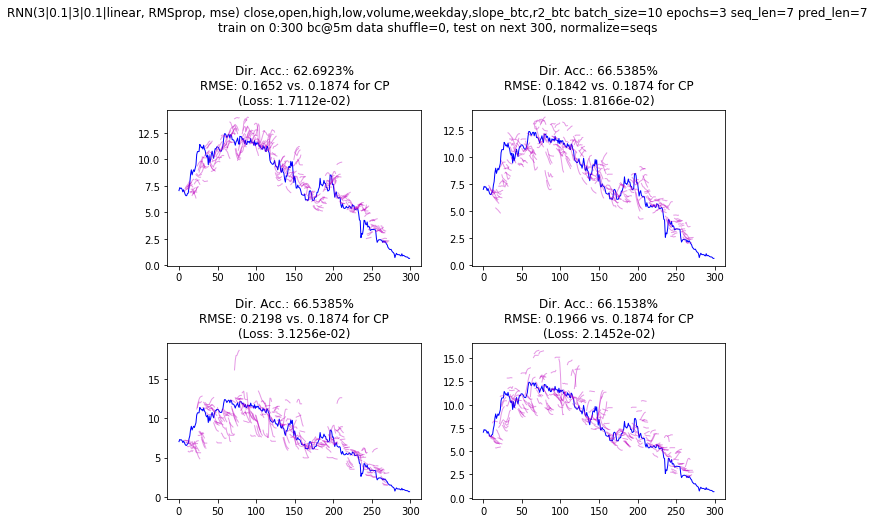

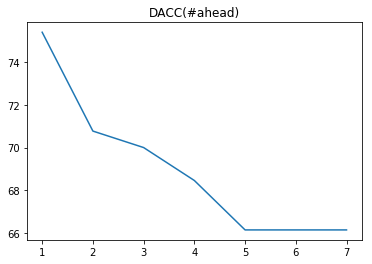

--- 94.071s to run experiment



        #################################
        # sieb
        #################################
        
data ~ (600, 8)
--- 0.019s to model compilation time


--- Created model id: 139985395200784
Tensor("lstm_155_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 7, 3)              144       
_________________________________________________________________
dropout_155 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_156 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)         

KeyboardInterrupt: 

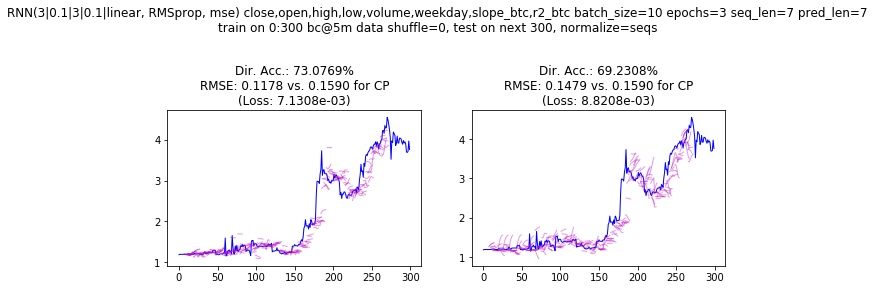

In [16]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday', 'slope_btc', 'r2_btc'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=3,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 139985332196240
Tensor("lstm_161_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_161 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_162 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 4         
Total params

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 14s 51ms/step - loss: 0.0147 - val_loss: 0.0091
Epoch 2/6
277/277 [==============================] - 0s 755us/step - loss: 0.0109 - val_loss: 0.0063
Epoch 3/6
277/277 [==============================] - 0s 739us/step - loss: 0.0088 - val_loss: 0.0046
Epoch 4/6
277/277 [==============================] - 0s 748us/step - loss: 0.0073 - val_loss: 0.0037
Epoch 5/6
277/277 [==============================] - 0s 768us/step - loss: 0.0065 - val_loss: 0.0030
Epoch 6/6
277/277 [==============================] - 0s 757us/step - loss: 0.0061 - val_loss: 0.0028
--- 17.295s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting 

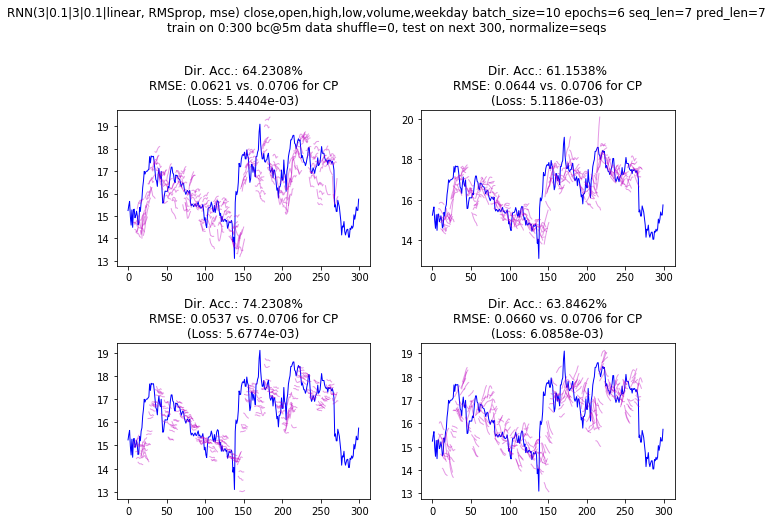

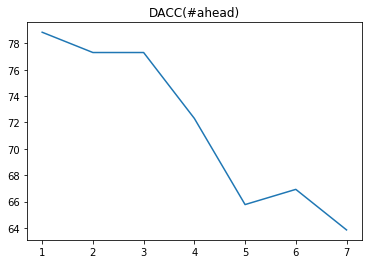

--- 101.758s to run experiment



In [17]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=6,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=4,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break



        #################################
        # ostk
        #################################
        
data ~ (600, 6)
--- 0.019s to model compilation time


--- Created model id: 139985959166096
Tensor("lstm_169_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_169 (LSTM)              (None, 7, 3)              120       
_________________________________________________________________
dropout_169 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_170 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_170 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 4         
Total params

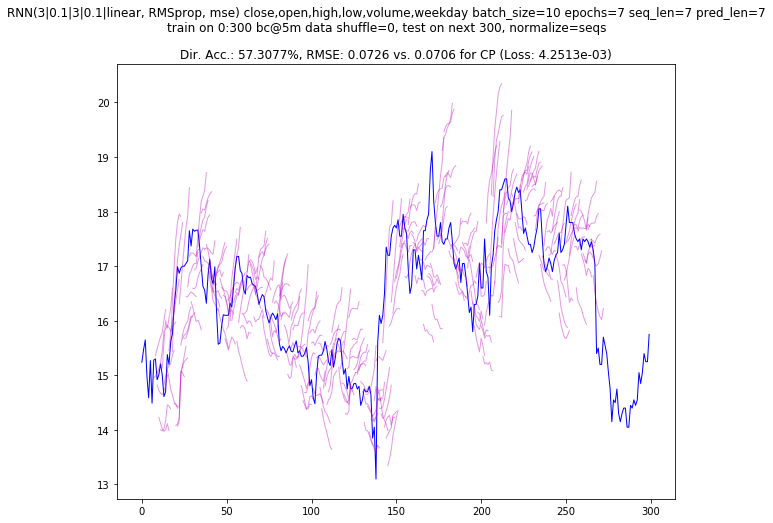

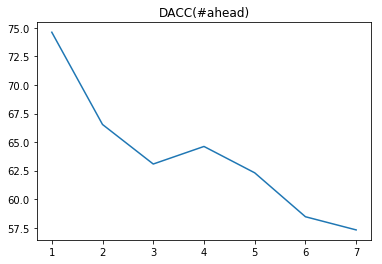

--- 26.330s to run experiment



In [18]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    with timing('run experiment'):
        run_walk_forward_validation_rnn(
            # data to extract:
            data,
            features=['close', 'open', 'high', 'low', 'volume',
                      'weekday'],
            from_i=0,
            train_sz=300,
            test_sz=300,
            # data processing:
            normalize='seqs',  # 'seqs' | 'data'
            detrend=False,
            # model and prediction arrangement:
            seq_len=7,
            pred_len=7,
            model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
            # training:
            epochs=7,
            batch_size=10,
            shuffle=False,
            # experiment setup:
            times=1,
            skip=False,
            fix_all_rngs_to=False,
            fix_rngs_before_each=False,
            # plotting:
            fig_size=(10, 8),
            fast=True,
        )
    break

## Full runs

In [22]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close', 'open', 'high', 'low', 'volume',
                 'weekday', 'slope_btc', 'r2_btc'],
    'train_sz': 600,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([4, 0.1, 3, 0.1]),
    # training:
    'epochs': 7,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [23]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [24]:
def full_run(idx_from, idx_to, data, out_filename, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(out_filename, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          data_df=data,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()



        #################################
        # ostk
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 139985393393424
Tensor("lstm_183_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_183 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_184 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_184 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_92 (Dense)      

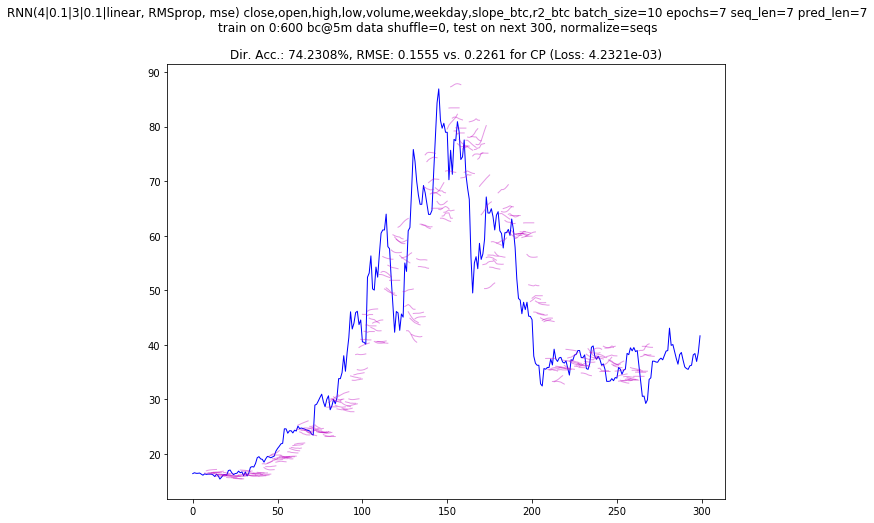

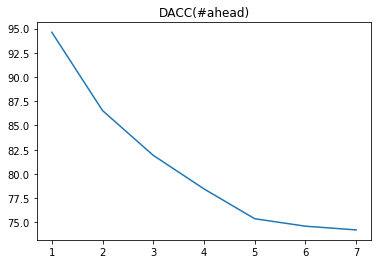

--- 30.348s to run segment

--- 30.348s to full run 600 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 139985139395984
Tensor("lstm_185_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_185 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_186 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_186 (Dropout)        (None, 3)                 0         
_________________________

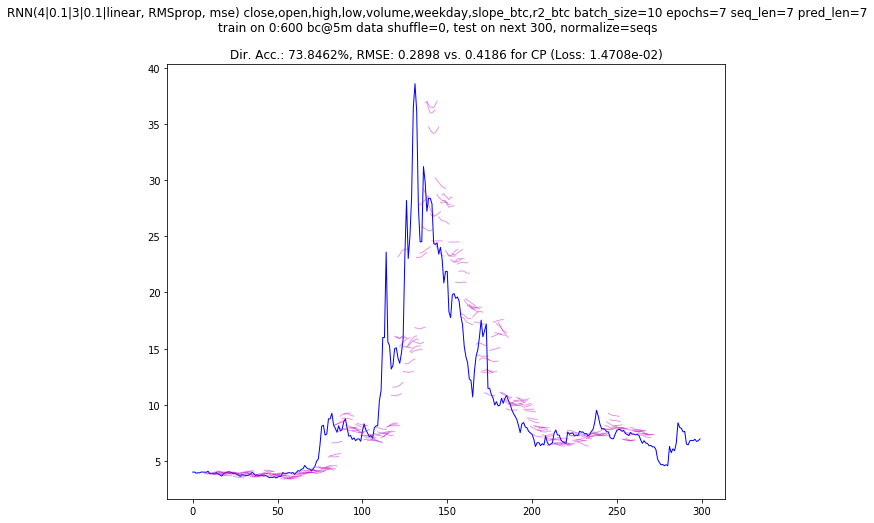

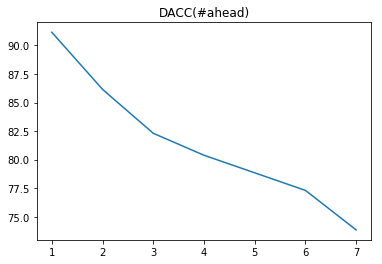

--- 31.799s to run segment

--- 31.799s to full run 600 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.033s to model compilation time


--- Created model id: 139985110233936
Tensor("lstm_187_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_187 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_188 (Dropout)        (None, 3)                 0         
__________________________

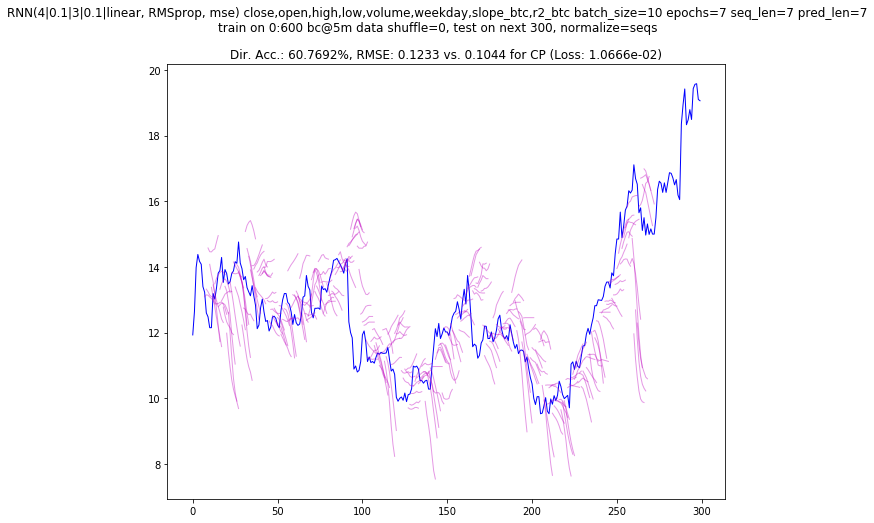

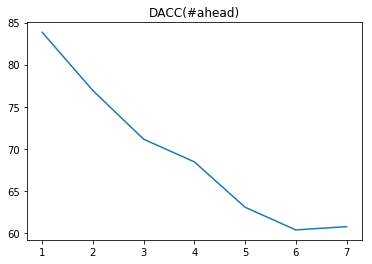

--- 31.738s to run segment

--- 31.738s to full run 600 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.020s to model compilation time


--- Created model id: 139985086943952
Tensor("lstm_189_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_189 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_189 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_190 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_190 (Dropout)        (None, 3)                 0         
_________________________

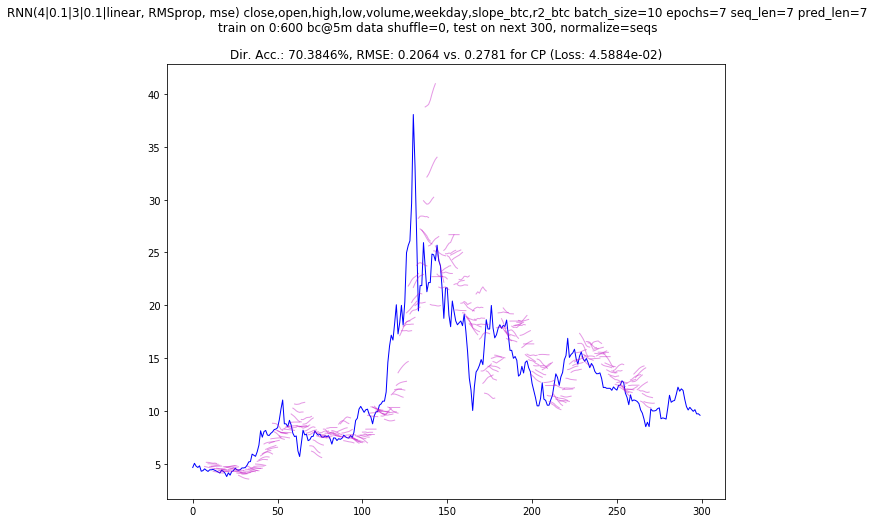

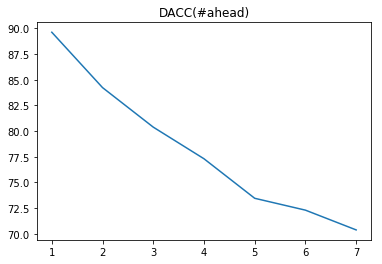

--- 30.282s to run segment

--- 30.282s to full run 600 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.019s to model compilation time


--- Created model id: 139985064558544
Tensor("lstm_191_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_191 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_191 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_192 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_192 (Dropout)        (None, 3)                 0         
_________________________

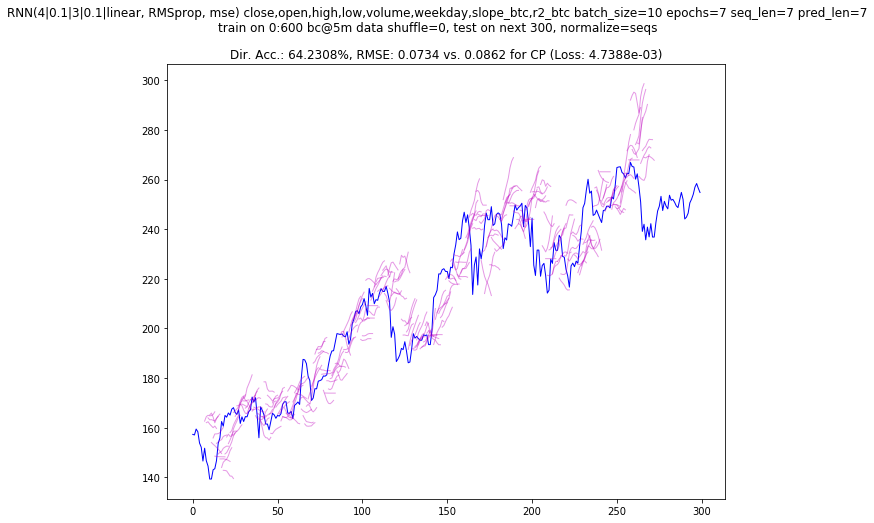

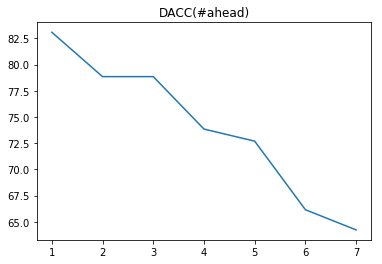

--- 32.532s to run segment

--- 32.533s to full run 600 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.021s to model compilation time


--- Created model id: 139985039962832
Tensor("lstm_193_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_193 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_193 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_194 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_194 (Dropout)        (None, 3)                 0         
_________________________

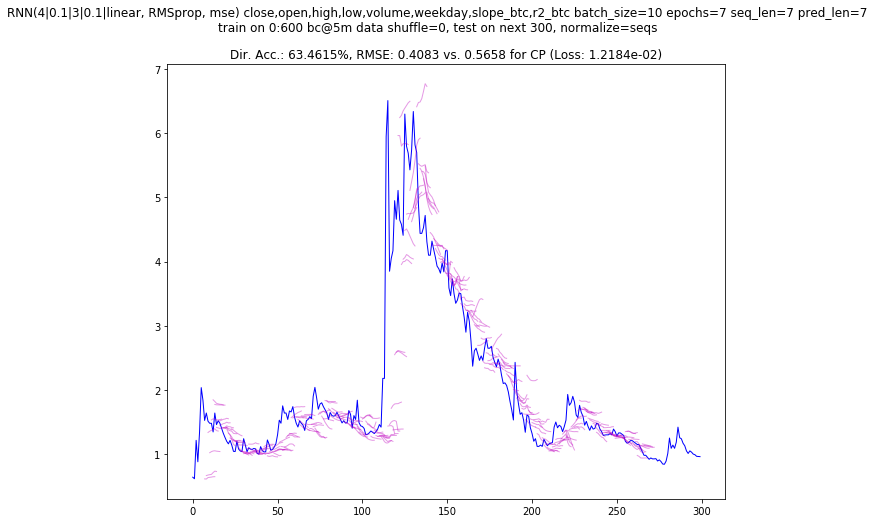

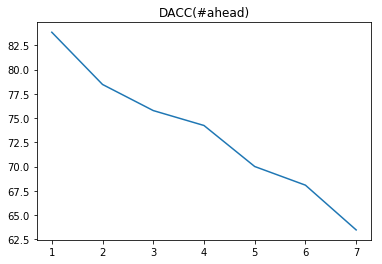

--- 30.683s to run segment

--- 30.683s to full run 600 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.019s to model compilation time


--- Created model id: 139985020197648
Tensor("lstm_195_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_195 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_195 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_196 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_196 (Dropout)        (None, 3)                 0         
_________________________

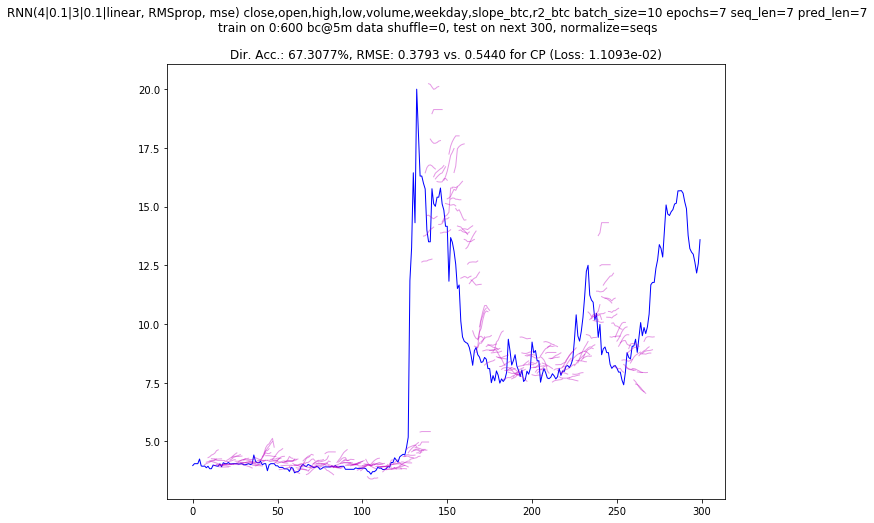

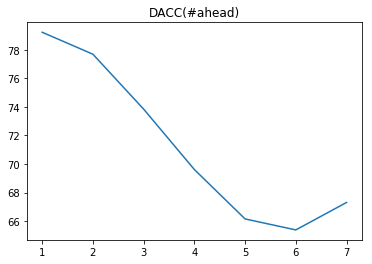

--- 32.619s to run segment

--- 32.619s to full run 600 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.027s to model compilation time


--- Created model id: 139984996917072
Tensor("lstm_197_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_197 (LSTM)              (None, 7, 4)              208       
_________________________________________________________________
dropout_197 (Dropout)        (None, 7, 4)              0         
_________________________________________________________________
lstm_198 (LSTM)              (None, 3)                 96        
_________________________________________________________________
dropout_198 (Dropout)        (None, 3)                 0         
________________________

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<Figure size 720x576 with 0 Axes>

In [25]:
for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(600, len(data) - 300, data,
             out_filename='./results/stock_%s_ohlcw_btc.csv' % stock,
             write_csv_header=True)

In [28]:
results = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_ohlcw_btc.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results[stock] = r



---------
> stock AMD: RMSE=0.1233% (vs. 0.1044% for CP), DACC=60.77%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.010666  0.1233   0.1044  60.7692



---------
> stock NVDA: RMSE=0.0734% (vs. 0.0862% for CP), DACC=64.23%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.004739  0.0734   0.0862  64.2308



---------
> stock GBTC: RMSE=0.2064% (vs. 0.2781% for CP), DACC=70.38%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.045884  0.2064   0.2781  70.3846



---------
> stock MARA: RMSE=0.4083% (vs. 0.5658% for CP), DACC=63.46%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.012184  0.4083   0.5658  63.4615



---------
> stock OSTK: RMSE=0.1555% (vs. 0.2261% for CP), DACC=74.23%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.004232  0.1555   0.2261  74.2308



---------
> stock OTIV: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock RIOT: RMSE=0.2898% (vs. 0.4186% for CP), DACC=73.85%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.014708  0.2898   0.4186  73.8462



---------
> stock SIEB: RMSE=0.3793% (vs. 0.5440% for CP), DACC=67.31%


model_description  train_from  train_to  \
0  RNN(4|0.1|3|0.1|linear, RMSprop, mse) close,op...           0       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.011093  0.3793    0.544  67.3077



        #################################
        # ostk
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.019s to model compilation time


--- Created model id: 139984920208272
Tensor("lstm_205_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_205 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_205 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_206 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_206 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_103 (Dense)     

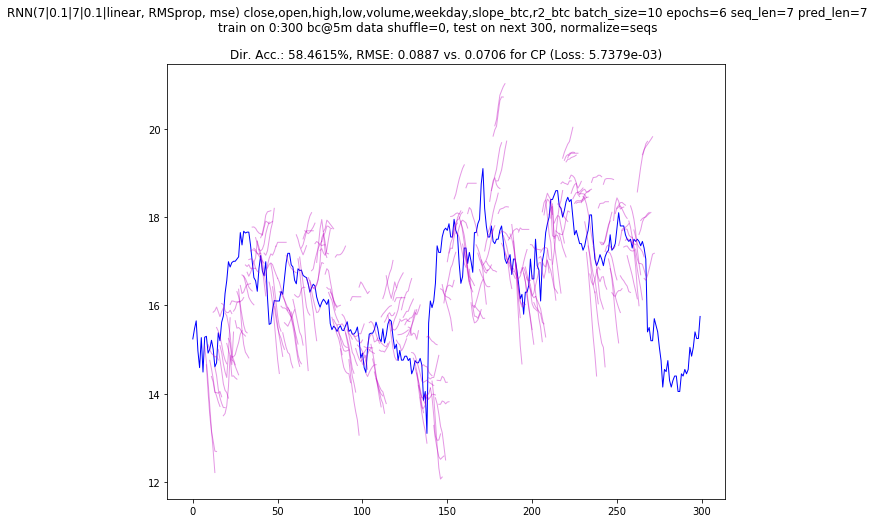

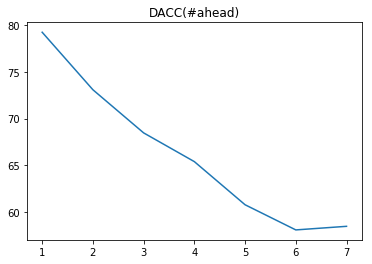

--- 30.808s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.020s to model compilation time


--- Created model id: 139984897938064
Tensor("lstm_207_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_207 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_207 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_208 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_208 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

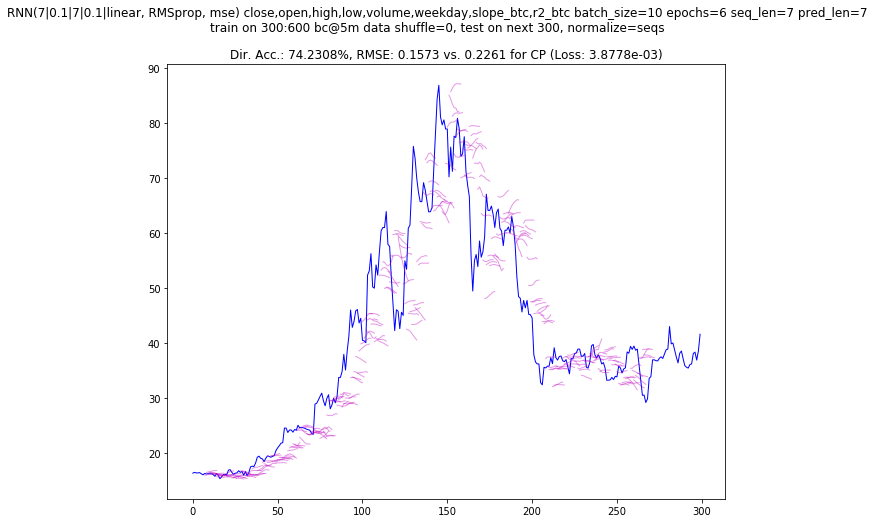

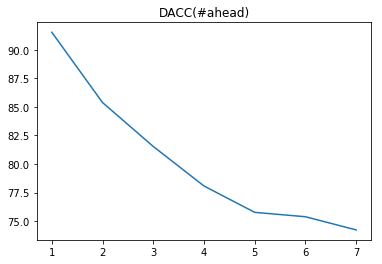

--- 31.524s to run segment

--- 62.332s to full run 300 - 645



        #################################
        # riot
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.018s to model compilation time


--- Created model id: 139984874848080
Tensor("lstm_209_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_209 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_209 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_210 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_210 (Dropout)        (None, 7)                 0         
_________________________

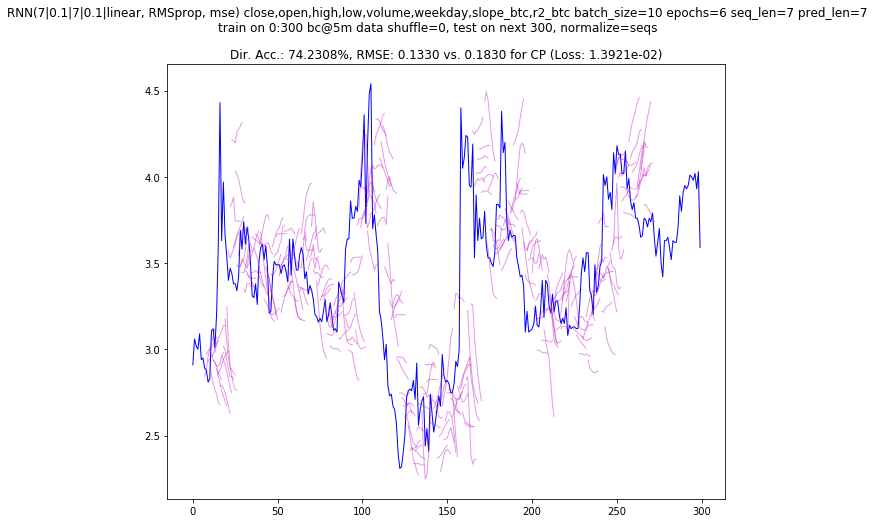

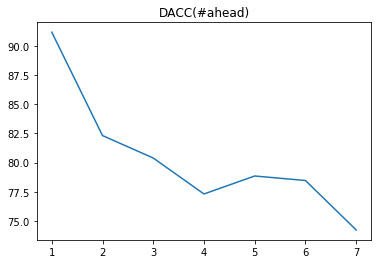

--- 31.717s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.020s to model compilation time


--- Created model id: 139984852789648
Tensor("lstm_211_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_211 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_211 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_212 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_212 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

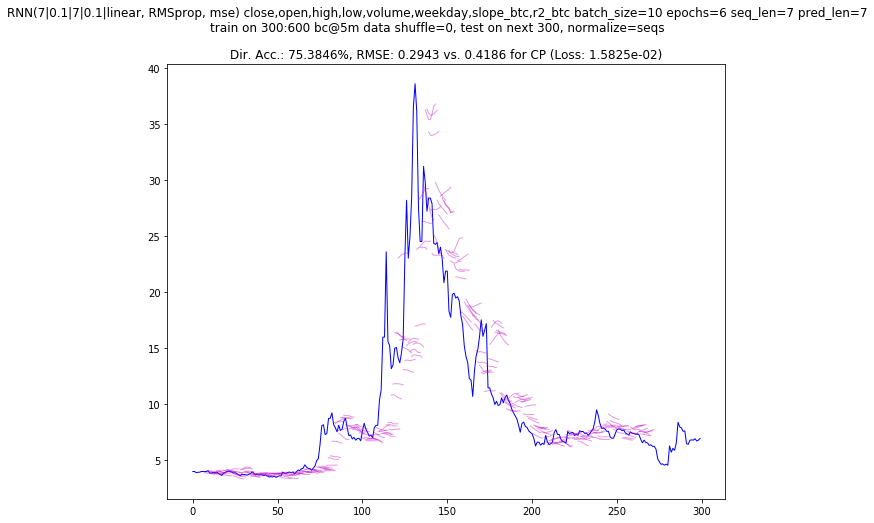

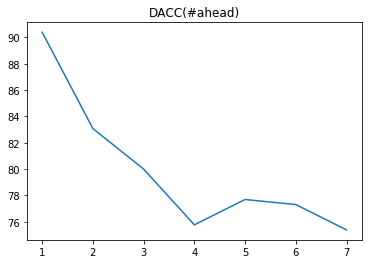

--- 32.049s to run segment

--- 63.767s to full run 300 - 645



        #################################
        # amd
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.029s to model compilation time


--- Created model id: 139984830957392
Tensor("lstm_213_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_213 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_213 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_214 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_214 (Dropout)        (None, 7)                 0         
__________________________

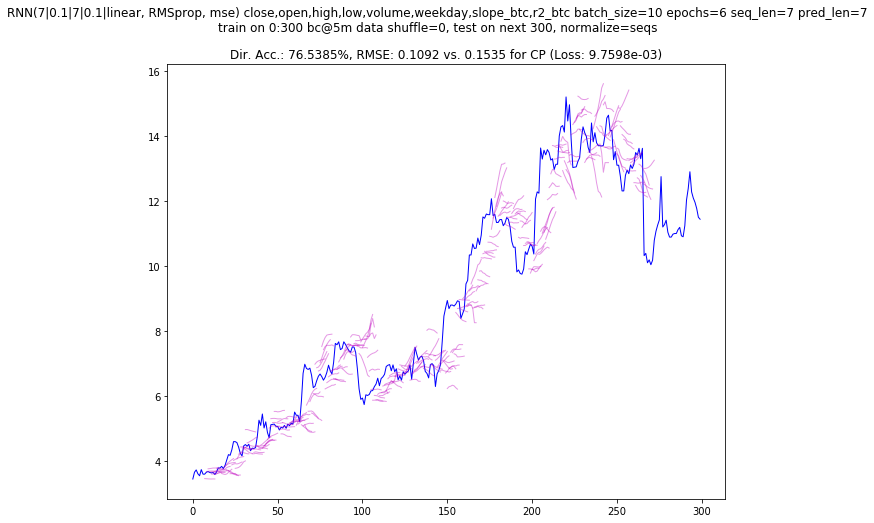

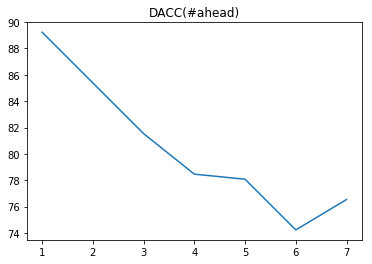

--- 33.543s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.027s to model compilation time


--- Created model id: 139984806725520
Tensor("lstm_215_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_215 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_215 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_216 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_216 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

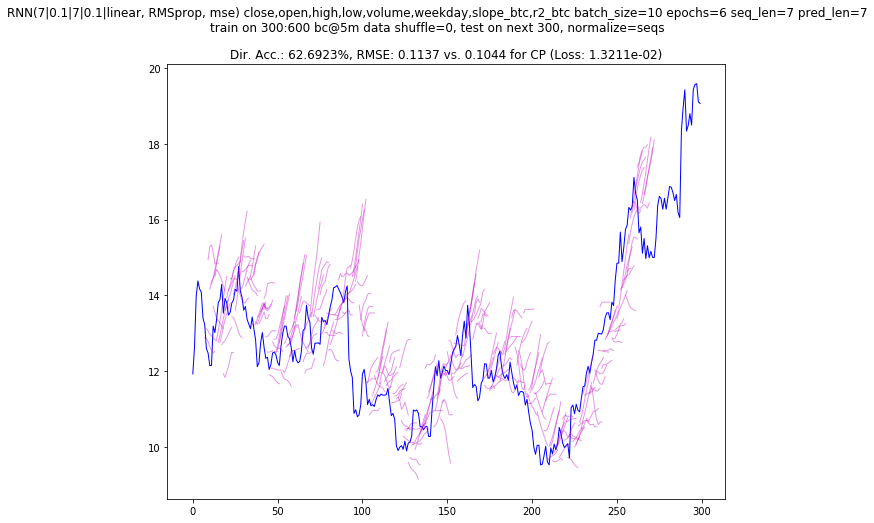

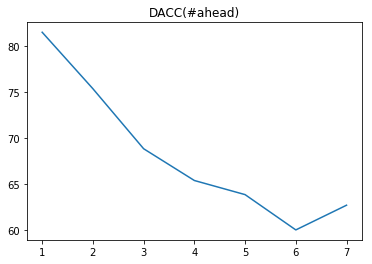

--- 33.921s to run segment

--- 67.465s to full run 300 - 645



        #################################
        # gbtc
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.024s to model compilation time


--- Created model id: 139984784483472
Tensor("lstm_217_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_217 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_217 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_218 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_218 (Dropout)        (None, 7)                 0         
_________________________

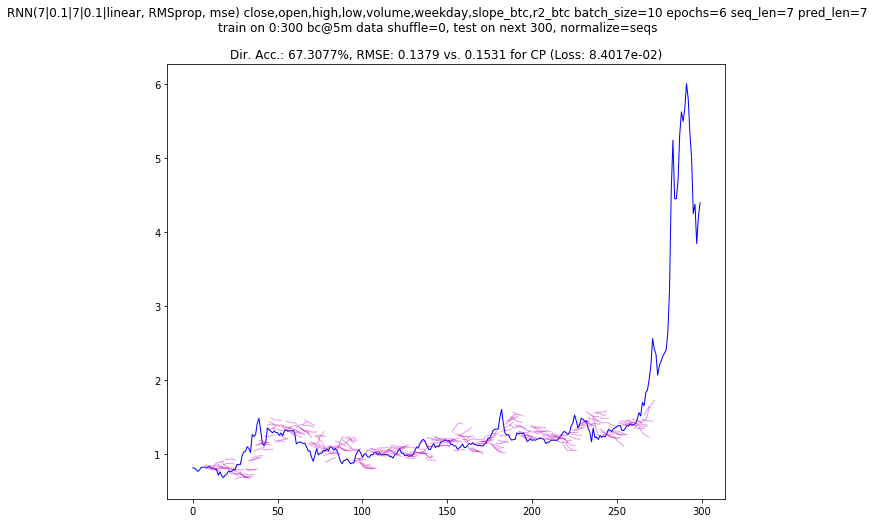

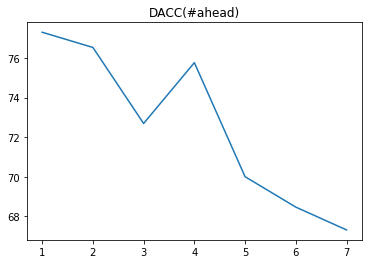

--- 55.238s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.025s to model compilation time


--- Created model id: 139984830381072
Tensor("lstm_219_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_219 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_219 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_220 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_220 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

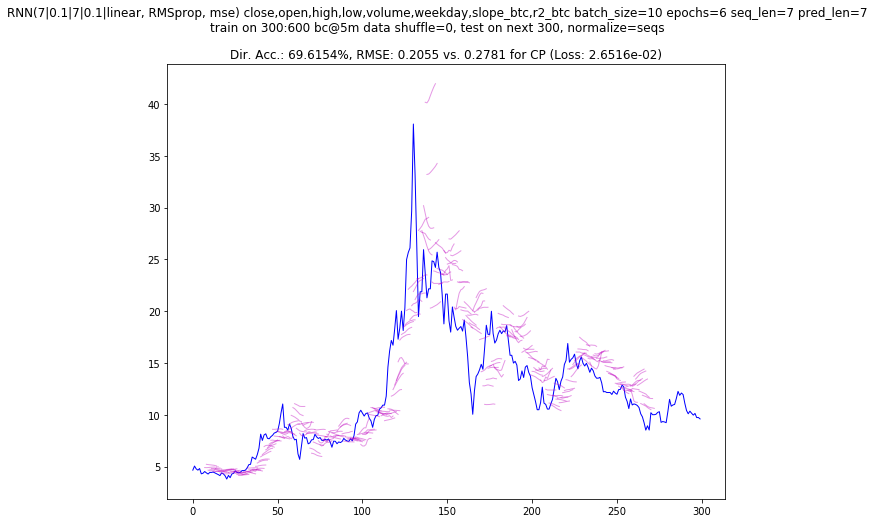

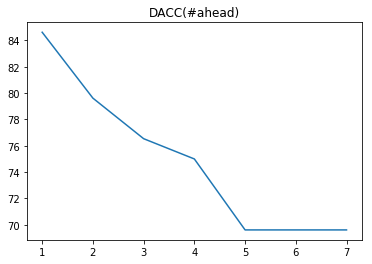

--- 35.250s to run segment

--- 90.488s to full run 300 - 645



        #################################
        # nvda
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.021s to model compilation time


--- Created model id: 139984783574736
Tensor("lstm_221_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_221 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_221 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_222 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_222 (Dropout)        (None, 7)                 0         
_________________________

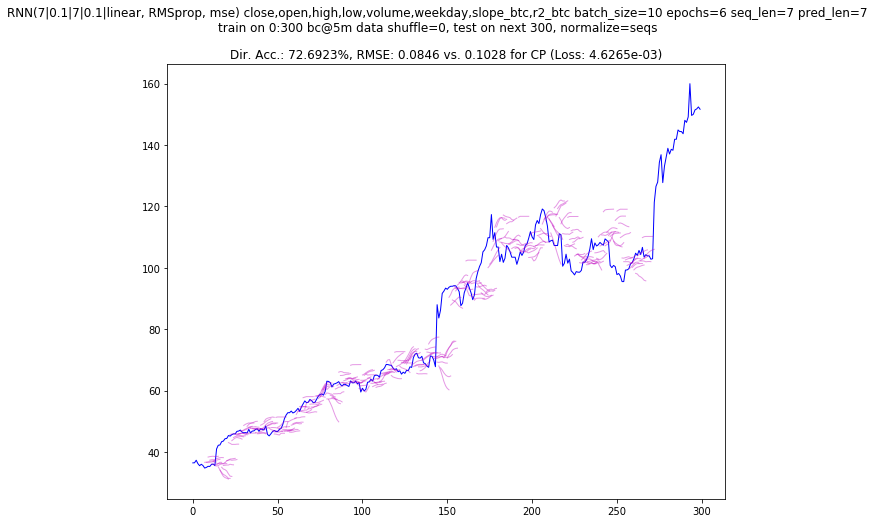

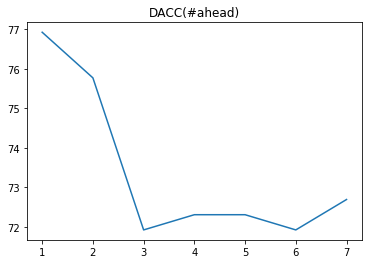

--- 34.801s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.020s to model compilation time


--- Created model id: 139985020924240
Tensor("lstm_223_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_223 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_223 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_224 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_224 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

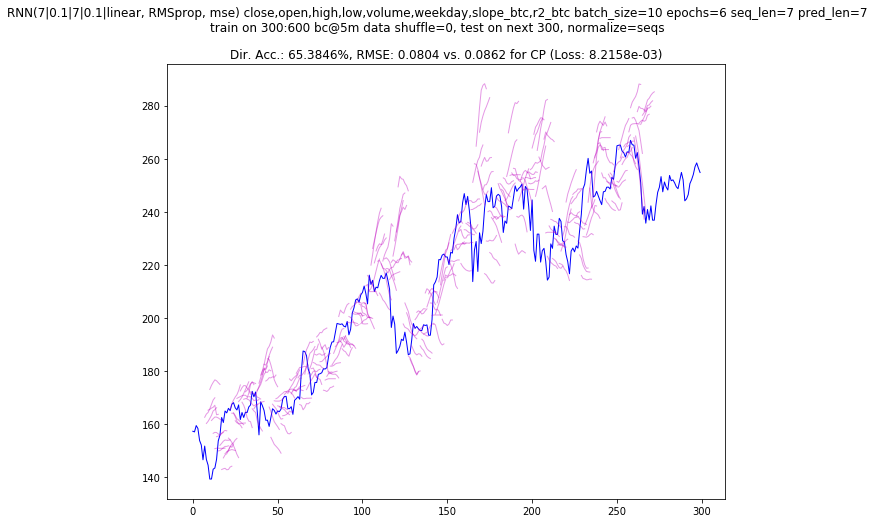

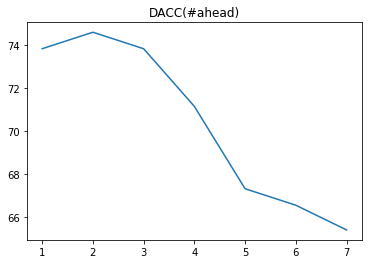

--- 34.938s to run segment

--- 69.739s to full run 300 - 645



        #################################
        # mara
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.029s to model compilation time


--- Created model id: 139984773343952
Tensor("lstm_225_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_225 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_225 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_226 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_226 (Dropout)        (None, 7)                 0         
_________________________

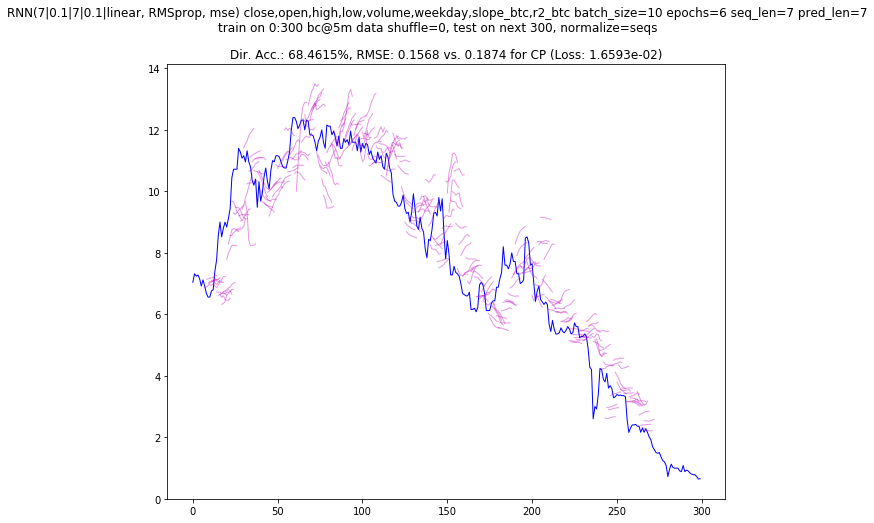

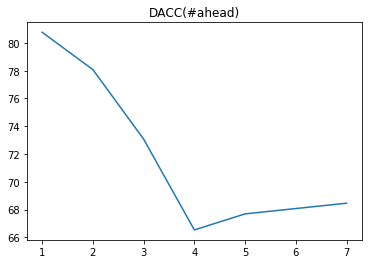

--- 37.215s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.021s to model compilation time


--- Created model id: 139984754118416
Tensor("lstm_227_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_227 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_227 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_228 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_228 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

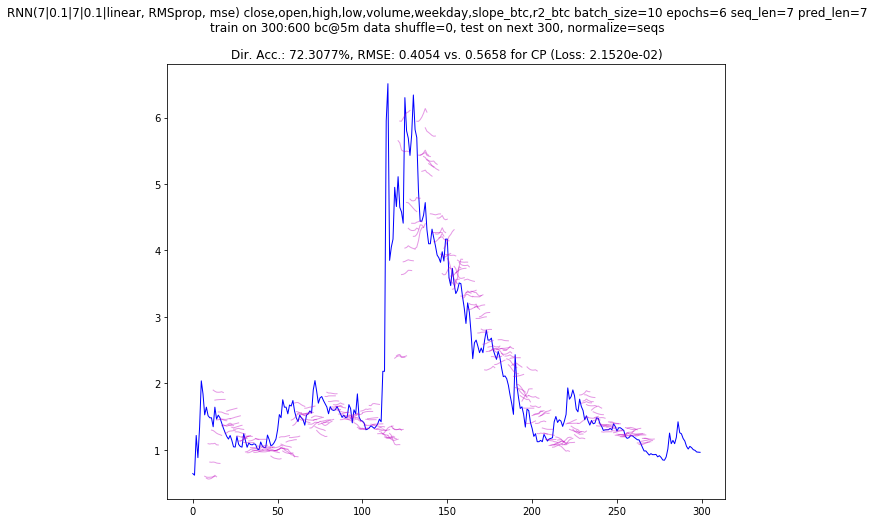

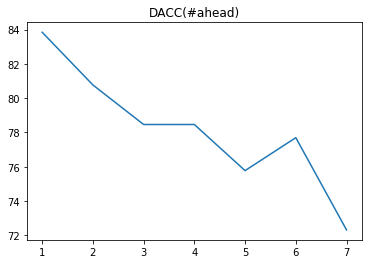

--- 37.765s to run segment

--- 74.981s to full run 300 - 645



        #################################
        # sieb
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.018s to model compilation time


--- Created model id: 139984753340496
Tensor("lstm_229_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_229 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_229 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_230 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_230 (Dropout)        (None, 7)                 0         
_________________________

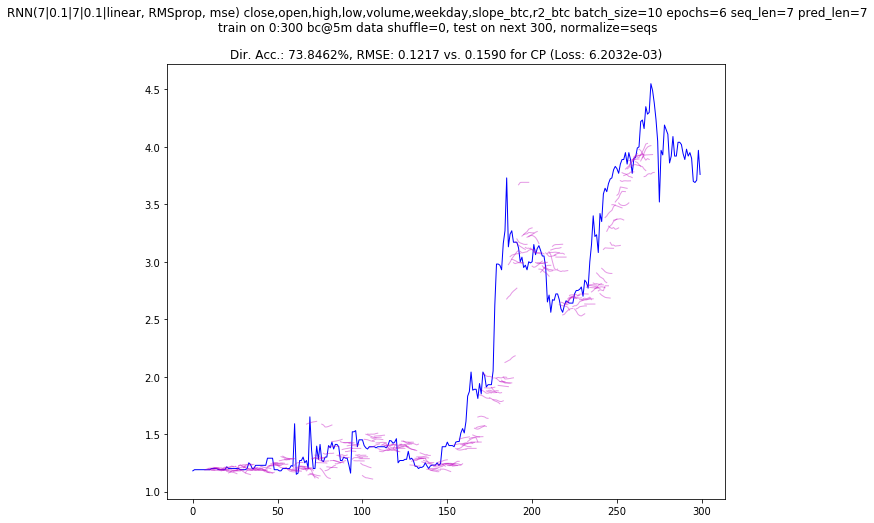

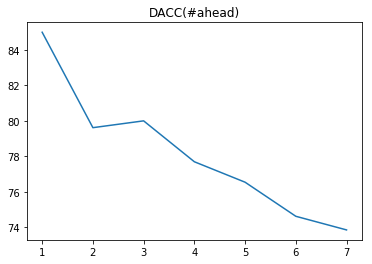

--- 34.748s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.018s to model compilation time


--- Created model id: 139984707314320
Tensor("lstm_231_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_231 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_231 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_232 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_232 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 8         
Total params: 876
Trainable params: 

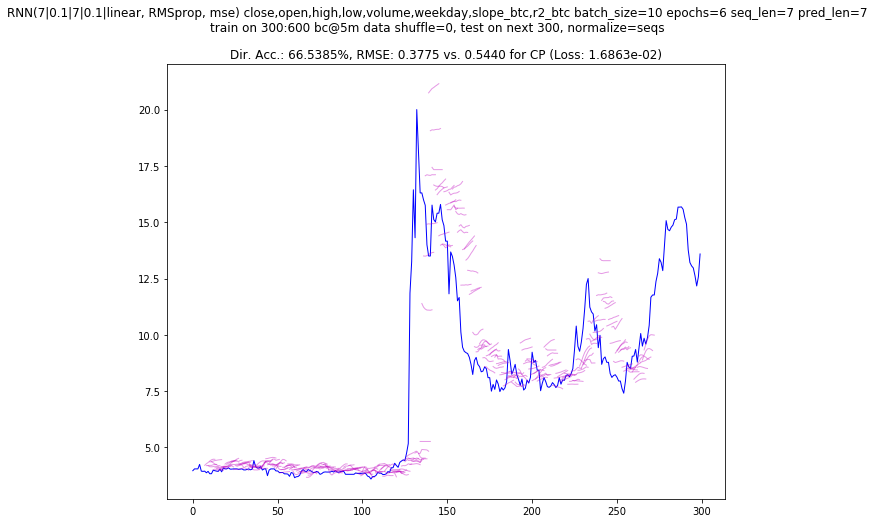

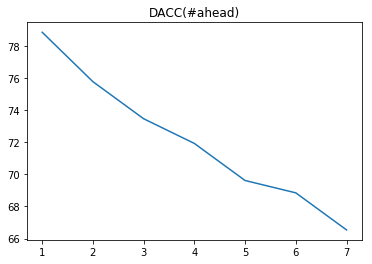

--- 34.112s to run segment

--- 68.860s to full run 300 - 645



        #################################
        # sp500
        #################################
        

   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.018s to model compilation time


--- Created model id: 139984684471952
Tensor("lstm_233_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_233 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_233 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_234 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_234 (Dropout)        (None, 7)                 0         
________________________

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<Figure size 720x576 with 0 Axes>

In [31]:
DEFAULT_PARAMS = {
    # data to extract:
    'features': ['close', 'open', 'high', 'low', 'volume',
                 'weekday', 'slope_btc', 'r2_btc'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([7, 0.1, 7, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

for stock, data in stocks_data.items():
    print("""\n
        #################################
        # %s
        #################################
        """ % stock)
    full_run(300, len(data) - 300, data,
             out_filename='./results/stock_%s_ohlcw_btc2.csv' % stock,
             write_csv_header=True)

In [33]:
results2 = {}
for stock in STOCKS:
    r = pd.read_csv('./results/stock_%s_ohlcw_btc2.csv' % stock)
    r['rmse'] = r['rmse'].str.replace('%', '').astype(float)
    r['rmse_cp'] = r['rmse_cp'].str.replace('%', '').astype(float)
    r['dir_acc'] = r['dir_acc'].str.replace('%', '').astype(float)
    print("\n\n---------")
    print("> stock %s: RMSE=%.4f%% (vs. %.4f%% for CP), DACC=%.2f%%" % (
        stock.upper(),
        r['rmse'].mean(), 
        r['rmse_cp'].mean(),
        r['dir_acc'].mean(),
    ))
    dd(r)
    results2[stock] = r



---------
> stock AMD: RMSE=0.1114% (vs. 0.1290% for CP), DACC=69.62%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.009760  0.1092   0.1535  76.5385  
1      300    False      seqs       0.013211  0.1137   0.1044  62.6923



---------
> stock NVDA: RMSE=0.0825% (vs. 0.0945% for CP), DACC=69.04%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.004627  0.0846   0.1028  72.6923  
1      300    False      seqs       0.008216  0.0804   0.0862  65.3846



---------
> stock GBTC: RMSE=0.1717% (vs. 0.2156% for CP), DACC=68.46%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.084017  0.1379   0.1531  67.3077  
1      300    False      seqs       0.026516  0.2055   0.2781  69.6154



---------
> stock MARA: RMSE=0.2811% (vs. 0.3766% for CP), DACC=70.38%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.016593  0.1568   0.1874  68.4615  
1      300    False      seqs       0.021520  0.4054   0.5658  72.3077



---------
> stock OSTK: RMSE=0.1230% (vs. 0.1483% for CP), DACC=66.35%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.005738  0.0887   0.0706  58.4615  
1      300    False      seqs       0.003878  0.1573   0.2261  74.2308



---------
> stock OTIV: RMSE=nan% (vs. nan% for CP), DACC=nan%


Empty DataFrame
Columns: [model_description, train_from, train_to, test_on, shuffle, normalize, training_loss, rmse, rmse_cp, dir_acc]
Index: []



---------
> stock RIOT: RMSE=0.2137% (vs. 0.3008% for CP), DACC=74.81%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.013921  0.1330   0.1830  74.2308  
1      300    False      seqs       0.015825  0.2943   0.4186  75.3846



---------
> stock SIEB: RMSE=0.2496% (vs. 0.3515% for CP), DACC=70.19%


model_description  train_from  train_to  \
0  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...           0       300   
1  RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,op...         300       600   

   test_on  shuffle normalize  training_loss    rmse  rmse_cp  dir_acc  
0      300    False      seqs       0.006203  0.1217    0.159  73.8462  
1      300    False      seqs       0.016863  0.3775    0.544  66.5385